In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['font.size']=14

In [2]:
def datetime_format(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y%m%d", errors='raise')
    df['년'] = df['일자'].dt.year
    df['월'] = df['일자'].dt.month
    df['일'] = df['일자'].dt.day
    df['주차'] = df['일자'].dt.weekofyear
    
    return df

def get_index_table(df, col_name = ""):
    df_index = df.pivot_table(index=['주차', '시명', '구명', '행정동명'],
                              values=[col_name], aggfunc='mean').reset_index()
    
    df_pre_corona = df_index[(df_index['주차'] == 4) | (df_index['주차'] == 5)]
#     df_pre_corona = df_index[(df_index['주차'] == 5)]
    df_pre_corona = df_pre_corona.pivot_table(index = ['시명', '구명', '행정동명'], values=col_name, aggfunc='mean')
    df_pre_corona.columns = [f"{col_name}_pre"]
    df_pre_corona = df_pre_corona.reset_index()
    
    df_corona = df_index[(df_index['주차'] == 10) | (df_index['주차'] == 11)]
#     df_corona = df_index[(df_index['주차'] == 11)]
    df_corona = df_corona.pivot_table(index = ['시명', '구명', '행정동명'], values=col_name, aggfunc='mean')
    df_corona.columns = [f"{col_name}_corona"]
    df_corona = df_corona.reset_index()
    
    df_index = df_pre_corona.merge(df_corona, how = 'inner', on = ['시명', '구명', '행정동명'])
    
    return df_index

def get_plot_gu_trend(df, x_axis, index = "", rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    df = df.pivot_table(index=['시명', '구명'], values=index, aggfunc='mean').reset_index()
    
    pal = sns.color_palette('Blues_r', df.shape[0])
    
    top_down_index = df[index].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index][x_axis].values
    
    sns.barplot(x = x_axis, y = index, data = df, order = plot_order)
    
    plt.axhline(df[index].mean())
    df = df.sort_values(by = index, ascending=False)
    df[index] = np.round(df[index], 2)
    
    for idx, score in enumerate(df[index]):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [3]:
fp = pd.read_csv("data/fpopl.csv")
card = pd.read_csv("data/card.csv")
delivery = pd.read_csv("data/delivery.csv")
dong = pd.read_csv("data/adstrd_master.csv")

In [4]:
fp = fp.merge(dong, on='adstrd_code', how= 'left')
card = card.merge(dong, on = 'adstrd_nm', how = 'left')

dong = dong[dong['brtc_nm'] == '서울특별시']

In [5]:
# 배달데이터는 서울시 425개의 행정동 중 약 122개의 행정동만 있음..
delivery = delivery[['PROCESS_DT','DLVR_STORE_INDUTY_NM',  'DLVR_STORE_SIDO',
       'DLVR_STORE_SIGUNGU', 'DLVR_STORE_DONG',
        'DLVR_DSTN_SIDO', 'DLVR_DSTN_SIGUNGU',
       'DLVR_DSTN_DONG', 'DLVR_AMOUNT',
       'CALL_RLAY_FEE_AMOUNT', 'GOODS_AMOUNT', 'SETLE_KND_VALUE']]

delivery2 = delivery.merge(dong, how='left',  left_on='DLVR_DSTN_DONG', right_on = 'adstrd_nm')
delivery2 = delivery2[(delivery2['DLVR_DSTN_SIDO'] == '서울특별시')]

delivery2['DLVR_DSTN_DONG'].nunique()

122

## 배달데이터는 약 122개의 행정동의 정보를 담고있으므로 분석에서 제외

In [6]:
card = card[card['brtc_nm'] == '서울특별시']
card['adstrd_nm'].nunique()

423

In [7]:
# fp에는 있고 card에는 없는 행정동명 색출
empty_dong = list(set(fp['adstrd_nm'].unique()) - set(card['adstrd_nm'].unique()))
empty_dong

['면목제3.8동']

## 카드데이터에 포함되지 않은 면목제3.8동은 분석에서 제외

In [8]:
empty_list = fp[[x == '면목제3.8동' for x in fp['adstrd_nm']]].index.to_list()

fp = fp.drop(empty_list, axis=0)

In [9]:
print(f"유동인구 데이터 행정동 갯수 : {fp['adstrd_nm'].nunique()}")
print(f"카드 데이터 행정동 갯수 : {card['adstrd_nm'].nunique()}")

유동인구 데이터 행정동 갯수 : 423
카드 데이터 행정동 갯수 : 423


In [10]:
fp = fp.drop(['tmzon_se_code', 'sexdstn_se_code', 'agrde_se_code',
       'adstrd_code'], axis=1)
card = card.drop(['adstrd_code_x', 'mrhst_induty_cl_code', 'adstrd_code_y'], axis=1)
fp.columns = ['일자', '유동인원', '행정동명', '시명', '구명']
card.columns = ['일자', '행정동명', '업종명', '이용건수', '이용금액', '시명', '구명']

In [11]:
data = [fp, card]

[datetime_format(x) for x in data]

fp.reset_index(drop = True, inplace=True)
card.reset_index(drop=True, inplace=True)

In [12]:
fp[fp['주차'] == 1]['일자'].drop_duplicates()

0         2020-01-01
282293    2020-01-02
564018    2020-01-03
845929    2020-01-04
1127874   2020-01-05
Name: 일자, dtype: datetime64[ns]

In [13]:
fp[fp['주차'] == 25]['일자'].drop_duplicates()

46869027   2020-06-15
47151782   2020-06-16
Name: 일자, dtype: datetime64[ns]

In [14]:
card[card['주차'] == 5]['일자'].drop_duplicates()

261607   2020-01-27
277307   2020-01-28
297886   2020-01-29
326594   2020-01-30
355689   2020-01-31
384820   2020-02-01
413948   2020-02-02
Name: 일자, dtype: datetime64[ns]

In [15]:
card[card['주차'] == 6]['일자'].drop_duplicates()

440525   2020-02-03
460333   2020-02-05
488958   2020-02-06
Name: 일자, dtype: datetime64[ns]

In [16]:
card[card['주차'] == 7]['일자'].drop_duplicates()

517397   2020-02-14
545940   2020-02-15
574586   2020-02-16
Name: 일자, dtype: datetime64[ns]

In [17]:
card[card['주차'] == 8]['일자'].drop_duplicates()

600825   2020-02-17
619887   2020-02-18
647524   2020-02-19
675907   2020-02-20
704349   2020-02-21
732813   2020-02-22
761042   2020-02-23
Name: 일자, dtype: datetime64[ns]

In [18]:
card[card['주차'] == 11]['일자'].drop_duplicates()

1142510   2020-03-09
1161036   2020-03-10
1188201   2020-03-11
1214339   2020-03-12
1241390   2020-03-13
1268096   2020-03-14
1295036   2020-03-15
Name: 일자, dtype: datetime64[ns]

In [19]:
card[card['주차'] == 24]['일자'].drop_duplicates()

3537425   2020-06-08
3557689   2020-06-09
3586522   2020-06-10
3615319   2020-06-11
3643795   2020-06-12
3672474   2020-06-13
3701167   2020-06-14
Name: 일자, dtype: datetime64[ns]

## 1, 25 주차의 데이터는 일주일 전체의 정보를 파악하기 힘들다 판단하여 분석에서 제외

In [20]:
fp = fp[fp['주차'].isin(range(2, 25))].reset_index(drop=True)
card = card[card['주차'].isin(range(2, 25))].reset_index(drop=True)

## 업종명 중분류

In [21]:
col = list(set(card['업종명']))
col.sort()

In [22]:
category = ['숙박업','숙박업','방송','홈쇼핑','연료','송금','상품권','패션','가전','가전','요식','건강','건강','건축','서비스',
'운송','잡화','스포츠','스포츠','스포츠','공공요금','공공요금','매점/편의점','설비','관광','교육','매점/편의점','자동차','자동차',
'패션','설비','관광','교육','교육','운송','가구','건강','건축','설비','운송','농업','서비스','스포츠','보험','유통',
'문구','문구','기타','숙박업','연료','서비스','유통','요식','의료','의류','자동차','잡화','기기','기타','주방','의류',
'회원제','회원제','회원제','회원제','회원제','의류','기기','유흥','농업','식품','식품','유흥','의류','스포츠','교육',
'대형할인점','교육','동물','스포츠','스포츠','렌트','의류','면세점','문구','문화','미용','식품','미용','예술','법률','법률','의료',
'보관창고','교육','인테리어','스포츠','부동산','부동산','비영리','농업','기타','비영리','사무','사무','사무','사무','개인',
'사우나','서비스','의료','상품권','상품권','보험','요식','문구','잡화','자동차','생활','컴퓨터','보험','스포츠','문화','자동차',
'대형마트','스포츠','식품','스포츠','스포츠','스포츠','패션','패션','잡화','의류','예술','패션','패션','마사지','동물','약국',
'잡화','운송','문구','문화','교육','의류','의류','문구','교육','면세점','방송','급식업','설비','연료','교육','교육','교육(해외)',
'유흥','설비','의료','의료','미용','통신','자동차','건강','인터넷쇼핑','인터넷쇼핑','인터넷쇼핑','인테리어','가구','문구',
'백화점','요식','요식','자동차','자동차','자동차','자동차','백화점','기타','장례','연료','문구','상우회','상품권(전자상)',
'상품권(전자상)','가전','식품','정기간행물','정보','의류','패션','식품','의료','가전','의료','조세','조세','스포츠','의료',
'용역','연료','자동차','주류','주방','주방','주점','자동차','자동차','요식','건축','운송','가구','교육','총포류','인쇄','의료',
'의료','생활','문화','자동차','카지노','주점','의류','컴퓨터','교육','숙박업','운송','운송','스포츠','통신','통신','통신','통신',
'통신','통신','통신','통신','숙박업','문화','인테리어','매점/편의점','미용','예술','교육','교육','의료','의료','의료','요식',
'항공','스포츠','혼례','혼례','건강','예술','문화','미용','유통','예술'
]

In [23]:
d= {} 
for i in range(260):
    d[col[i]] = category[i]

In [24]:
d

{'1급 호텔': '숙박업',
 '2급 호텔': '숙박업',
 'CATV': '방송',
 'CATV홈쇼핑': '홈쇼핑',
 'L P G': '연료',
 'P2P송금': '송금',
 'PG 상품권': '상품권',
 '가   방': '패션',
 '가전 제품': '가전',
 '가정용품수리': '가전',
 '갈비전문점': '요식',
 '건강식품(회원제형태)': '건강',
 '건강진단': '건강',
 '건축요업품': '건축',
 '견인서비스': '서비스',
 '고속 버스': '운송',
 '골동품 점': '잡화',
 '골프 용품': '스포츠',
 '골프경기장': '스포츠',
 '골프연습장': '스포츠',
 '공공 요금': '공공요금',
 '공공요금/대상': '공공요금',
 '공무원연금매점': '매점/편의점',
 '과학기자재': '설비',
 '관광여행': '관광',
 '교육테이프': '교육',
 '구내매점(국가기관등)': '매점/편의점',
 '국산 신차': '자동차',
 '국산신차직영부품/정비업소': '자동차',
 '귀 금 속': '패션',
 '기계 공구': '설비',
 '기념품 점': '관광',
 '기능학원': '교육',
 '기타 교육': '교육',
 '기타 운송': '운송',
 '기타가구': '가구',
 '기타건강식': '건강',
 '기타건축자재': '건축',
 '기타광학품': '설비',
 '기타교통수단': '운송',
 '기타농업관련': '농업',
 '기타대인서비스': '서비스',
 '기타레져업': '스포츠',
 '기타보험': '보험',
 '기타비영리유통': '유통',
 '기타사무용품': '문구',
 '기타서적문구': '문구',
 '기타수리서비스': '기타',
 '기타숙박업': '숙박업',
 '기타연료': '연료',
 '기타용역서비스': '서비스',
 '기타유통업': '유통',
 '기타음료식품': '요식',
 '기타의료기관및기타의료기기': '의료',
 '기타의류': '의류',
 '기타자동차서비스': '자동차',
 '기타잡화': '잡화',
 '기타전기제품': '기기',


In [25]:
card['업종명'] = card['업종명'].replace(d)

remove = ['공공요금','개인','기타','비영리','상우회','정보','회원제','총포류','카지노','송금','조세','농업','설비', '숙박업', '방송', '서비스', '운송', '관광', 
         '보험', '회원제', '법률', '보관창고', '부동산', '사우나', '유흥', '장례', '상우회', '정기간행물', '용역', '통신', '건축', '기타', '연료', '항공', "교육(해외)"]
card = card[~card['업종명'].isin(remove)]

In [26]:
card['업종명'].nunique()

41

## 43개의 분류된 업종으로 분석

# 이용금액이 음수거나 이용 건수가 0이하인 경우 분석대상 제외

In [27]:
negative_index = card[(card['이용금액'] <= 0) | (card['이용건수'] <= 0)].index

card = card.drop(negative_index)

card = card.reset_index(drop=True)

<ipython-input-117-46739f00ae1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  korea_corona['Date'] = pd.to_datetime(korea_corona['Date'], format='%Y-%m-%d')
<ipython-input-117-46739f00ae1c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  korea_corona['year'] = korea_corona['Date'].dt.year
<ipython-input-117-46739f00ae1c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<Figure size 1296x432 with 0 Axes>

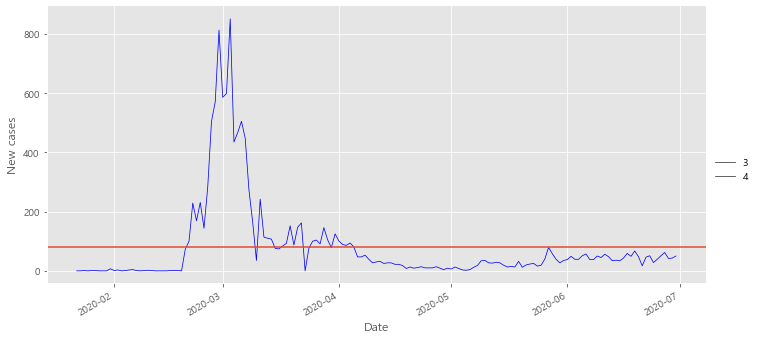

In [117]:
# 코로나 데이터 로드(from Kaggle)
corona = pd.read_csv("data/corona/full_grouped.csv")

# 한국 확진자 데이터만 확보
korea_corona = corona[corona['Country/Region'] == 'South Korea']
korea_corona.reset_index(drop=True, inplace=True)

# 분석 대상인 6월까지 일단 추출
korea_corona['Date'] = pd.to_datetime(korea_corona['Date'], format='%Y-%m-%d')
korea_corona['year'] = korea_corona['Date'].dt.year
korea_corona['month'] = korea_corona['Date'].dt.month
korea_corona['day'] = korea_corona['Date'].dt.day
korea_corona['week'] = korea_corona['Date'].dt.weekofyear

korea_corona = korea_corona[korea_corona['month'].isin(range(1, 7))]

# 일자별 코로나 추이
plt.figure(figsize=(18,6))
g = sns.relplot(x='Date', y='New cases', data = korea_corona, kind='line', size=4, aspect=2, color = 'blue')
g.fig.autofmt_xdate()


plt.style.use('ggplot')
plt.axhline(korea_corona['New cases'].mean())

## 코로나 확산기에 각 동이 보여주는 특징을 잡아 군집화 한 후 각 집단의 코로나 안정기의 소비 행태를 분석하면 진정한 뉴노멀 소대의 소비 트랜드를 보여줄 수 있지 않을까?

## 1. 구간정의 

### 파랑색 부분 : 코로나 불안 이전 사람들이 보여주는 소비

### 빨강색 부분 : 코로나로 인해 사람들의 소비 심리가 위축된 구간 => 코로나에 반응하는 지수를 산출해낼것(파랑색 대비)

### 초록색 부분 : 코로나가 어느정도 안정되었다고 가정할 수 있는 구간(주어진 데이터 내) => 뉴노멀 소비 트랜드를 보여줄 수 있는 구간이라 생각




## 2. 지수 산출

### 파랑색 - 빨강색 => 코로나19로 인한 각 행정동들의 반응을 지수로 산출 (Ex. 유동인구가 줄었든 늘었든, 카드소비가 늘었든 줄었든)




## 3. 지수를 통한 비슷한 특징을 지니는 행정동 색출

### 산출해낸 지수를 바탕으로 군집화 예정 => 집단 색출
### 군집별 특징을 파악해 IN & OUT 지표 생성




## 4. 아이디어 제안

### 집단 특성에 어울리는 서비스 아이디어!

# 자동차와 관련된 산업군을 따로 추려냄 & 인터넷을 사용한 소비와 관련된 산업군(= 물류로 해석)

In [118]:
related_car = ['자동차']

related_logistic = ['인터넷쇼핑', '홈쇼핑']

remove_industry = set(related_car + related_logistic)

industry = set(card['업종명'].unique())

card_industry = list(industry - remove_industry)

car_index = [idx for idx, x in enumerate(card['업종명']) if x in related_car]
logistic_index = [idx for idx, x in enumerate(card['업종명']) if x in related_logistic]
normal_index = [idx for idx, x in enumerate(card['업종명']) if x in card_industry]

car_df = card.iloc[car_index, :]
logistic_df = card.iloc[logistic_index, :]
card_df = card.iloc[normal_index, :]

car_df = car_df.reset_index(drop=True)
logistic_df = logistic_df.reset_index(drop=True)
card_df = card_df.reset_index(drop=True)

# 차량 관련 데이터

#### 차량 변화지수 계산하기

#### 4-5주차를 100으로 보고 9-10주차의 차량지수 산출
(코로나 이전의 소비 -> 코로나가 확산될 때를 보기 위함)

In [185]:
car_df_index = get_index_table(car_df, '이용건수')

car_df_index['차량지수'] = (car_df_index['이용건수_corona'] * 100) / car_df_index['이용건수_pre']

In [186]:
car_df_index

,시명,구명,행정동명,이용건수_pre,이용건수_corona,차량지수
0,서울특별시,강남구,개포1동,1.000000,1.000000,100.000000
1,서울특별시,강남구,개포2동,5.659091,5.796218,102.423138
2,서울특별시,강남구,개포4동,4.196360,3.976166,94.752742
3,서울특별시,강남구,논현1동,37.136364,29.288633,78.867801
4,서울특별시,강남구,논현2동,24.041667,21.206548,88.207477
...,...,...,...,...,...,...
412,서울특별시,중랑구,상봉2동,3.857143,3.318302,86.030062
413,서울특별시,중랑구,신내1동,4.651282,2.912516,62.617488
414,서울특별시,중랑구,신내2동,8.348214,10.777778,129.102793
415,서울특별시,중랑구,중화1동,2.472222,3.214286,130.016051


## 평균적인 차량 지수

In [187]:
car_df_index['차량지수'].mean()

89.61283619788965

In [188]:
car_df_index.groupby("구명")['차량지수'].mean()

구명
강남구      84.857128
강동구      74.675690
강북구     109.001992
강서구     104.810300
관악구      88.794131
광진구      76.851382
구로구      83.154613
금천구      87.061927
노원구      84.557439
도봉구     100.051415
동대문구     87.068588
동작구      85.508233
마포구      83.226139
서대문구     81.273760
서초구      98.313328
성동구      92.427416
성북구      78.738360
송파구      82.484061
양천구      88.858277
영등포구     86.203141
용산구     113.385333
은평구      84.418014
종로구     115.845954
중구       85.396639
중랑구      92.520279
Name: 차량지수, dtype: float64

## 서울시 구별 차량지수 시각화

,시명,구명,차량지수
22,서울특별시,종로구,115.85
20,서울특별시,용산구,113.39
2,서울특별시,강북구,109.00
3,서울특별시,강서구,104.81
9,서울특별시,도봉구,100.05
14,서울특별시,서초구,98.31
24,서울특별시,중랑구,92.52
15,서울특별시,성동구,92.43
18,서울특별시,양천구,88.86
4,서울특별시,관악구,88.79


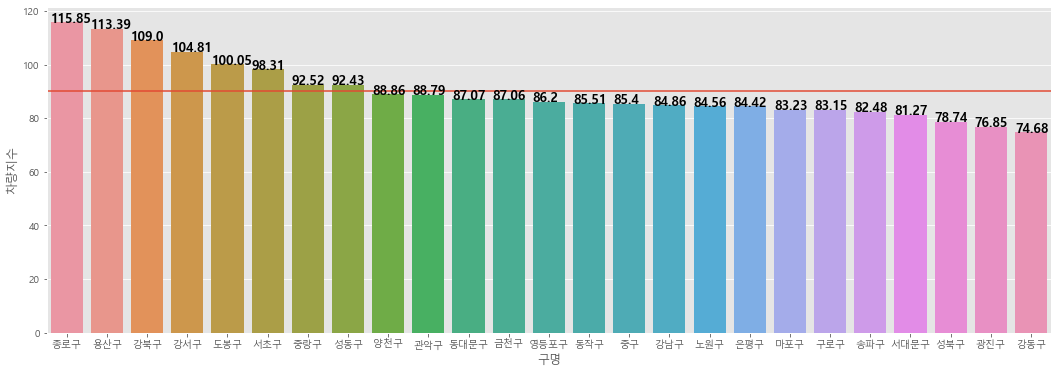

In [189]:
get_plot_gu_trend(car_df_index, '구명', '차량지수')

# 물류 관련 데이터

#### 물류 변화지수 계산하기

#### 4-5주차를 100으로 보고 9-10주차의 물류지수 산출
(코로나 이전의 소비 -> 코로나가 확산될 때를 보기 위함)

In [124]:
logistic_df_index = get_index_table(logistic_df, '이용건수')

logistic_df_index['물류지수'] = (logistic_df_index['이용건수_corona'] * 100) / logistic_df_index['이용건수_pre']

# 평균적인 물류 지수

In [125]:
logistic_df_index['물류지수'].mean()

108.70602179379209

# 서울시 구별 물류지수 시각화

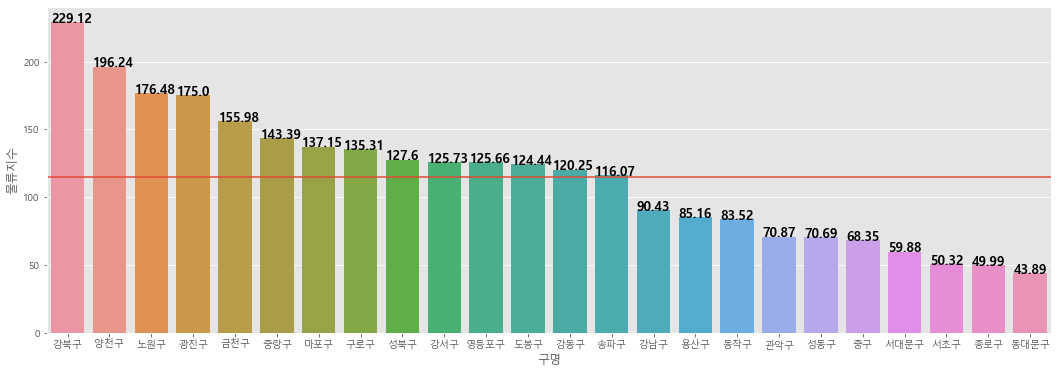

In [126]:
get_plot_gu_trend(logistic_df_index, '구명', '물류지수')

# 유동인구 데이터

#### 유동인구 변화지수 계산하기

#### 5-6주차를 100으로 보고 7-8주차의 유동지수 산출
(코로나 이전의 소비 -> 코로나가 확산될 때를 보기 위함)

In [127]:
fp_index = get_index_table(fp, '유동인원')

fp_index['유동지수'] = (fp_index['유동인원_corona'] * 100) / fp_index['유동인원_pre']

In [128]:
fp_index

,시명,구명,행정동명,유동인원_pre,유동인원_corona,유동지수
0,서울특별시,강남구,개포1동,62.690121,61.333019,97.835223
1,서울특별시,강남구,개포2동,161.117104,178.204833,110.605782
2,서울특별시,강남구,개포4동,91.560209,102.526257,111.976871
3,서울특별시,강남구,논현1동,327.688136,332.757118,101.546892
4,서울특별시,강남구,논현2동,323.653235,338.508234,104.589788
...,...,...,...,...,...,...
419,서울특별시,중랑구,상봉2동,194.615043,166.918764,85.768685
420,서울특별시,중랑구,신내1동,265.835543,220.911232,83.100713
421,서울특별시,중랑구,신내2동,81.130126,88.203250,108.718246
422,서울특별시,중랑구,중화1동,96.189895,89.381565,92.921990


# 평균적인 유동지수

In [129]:
fp_index['유동지수'].mean()

92.27222444843954

## 서울시 구별 유동지수 시각화

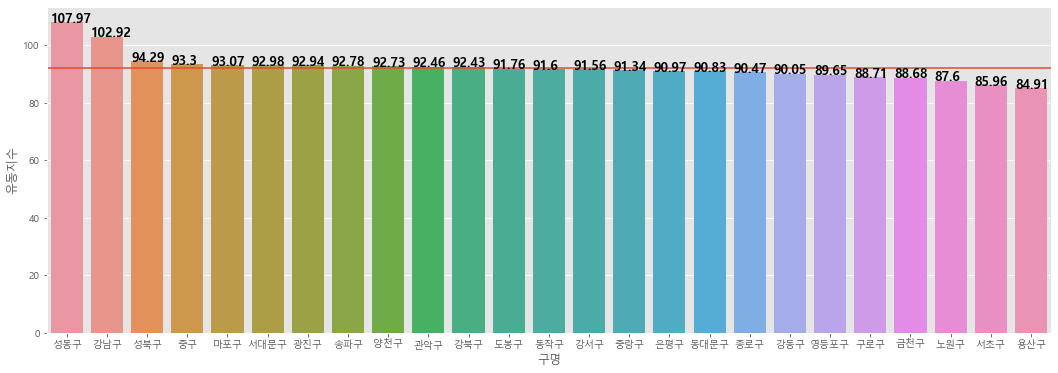

In [130]:
get_plot_gu_trend(fp_index, '구명', '유동지수')

In [131]:
fp_index['유동지수'].mean()

92.27222444843954

In [132]:
pop_index = fp_index.pivot_table(index=['시명','구명'], values='유동지수', aggfunc='mean').reset_index()
logistic_index = logistic_df_index.pivot_table(index=['시명','구명'], values='물류지수', aggfunc='mean').reset_index()
car_index = car_df_index.pivot_table(index=['시명','구명'], values='차량지수', aggfunc='mean').reset_index()
# card_index = card_df_index.pivot_table(index=['시명','구명'], values='지출지수', aggfunc='mean').reset_index()

index_group = pop_index.merge(logistic_index, how='left', on=['시명', '구명'])
index_group = index_group.merge(car_index, how='left', on=['시명', '구명'])
# index_group = index_group.merge(card_index, how='left', on=['시명', '구명'])

index_group

,시명,구명,유동지수,물류지수,차량지수
0,서울특별시,강남구,102.920050,90.428241,84.857128
1,서울특별시,강동구,90.047754,120.252112,74.675690
2,서울특별시,강북구,92.429118,229.120879,109.001992
3,서울특별시,강서구,91.561682,125.734487,104.810300
4,서울특별시,관악구,92.463960,70.872633,88.794131
5,서울특별시,광진구,92.944550,175.000000,76.851382
6,서울특별시,구로구,88.705149,135.310522,83.154613
7,서울특별시,금천구,88.677544,155.984442,87.061927
8,서울특별시,노원구,87.598956,176.483126,84.557439
9,서울특별시,도봉구,91.757884,124.444444,100.051415


#### 값 비교가 불가능한 ['은평구']는 분석에서 제외

In [133]:
index = [21]

index_group = index_group.drop(index)

index_group = index_group.reset_index(drop=True)

In [134]:
index_group

,시명,구명,유동지수,물류지수,차량지수
0,서울특별시,강남구,102.920050,90.428241,84.857128
1,서울특별시,강동구,90.047754,120.252112,74.675690
2,서울특별시,강북구,92.429118,229.120879,109.001992
3,서울특별시,강서구,91.561682,125.734487,104.810300
4,서울특별시,관악구,92.463960,70.872633,88.794131
5,서울특별시,광진구,92.944550,175.000000,76.851382
6,서울특별시,구로구,88.705149,135.310522,83.154613
7,서울특별시,금천구,88.677544,155.984442,87.061927
8,서울특별시,노원구,87.598956,176.483126,84.557439
9,서울특별시,도봉구,91.757884,124.444444,100.051415


In [135]:
index_group['result_flow'] = ['up' if x > index_group['유동지수'].mean() else 'down'
                             for x in index_group['유동지수']]

index_group['result_car'] = ['up' if x > index_group['차량지수'].mean() else 'down'
                             for x in index_group['차량지수']]

index_group['result_logi'] = ['up' if x > index_group['물류지수'].mean() else 'down'
                             for x in index_group['물류지수']]

In [136]:
index_group

,시명,구명,유동지수,물류지수,차량지수,result_flow,result_car,result_logi
0,서울특별시,강남구,102.920050,90.428241,84.857128,up,down,down
1,서울특별시,강동구,90.047754,120.252112,74.675690,down,down,up
2,서울특별시,강북구,92.429118,229.120879,109.001992,up,up,up
3,서울특별시,강서구,91.561682,125.734487,104.810300,down,up,up
4,서울특별시,관악구,92.463960,70.872633,88.794131,up,down,down
5,서울특별시,광진구,92.944550,175.000000,76.851382,up,down,up
6,서울특별시,구로구,88.705149,135.310522,83.154613,down,down,up
7,서울특별시,금천구,88.677544,155.984442,87.061927,down,down,up
8,서울특별시,노원구,87.598956,176.483126,84.557439,down,down,up
9,서울특별시,도봉구,91.757884,124.444444,100.051415,down,up,up


## => 드라이브 스루와 구독경제 모두 유동인구는 적어야 한다 생각..

# 정리 : 유동 down, 차량 up => 드라이브 스루
#        : 유동 down, 물류 up => 구독경제

In [137]:
# 구독경제 적합지역 분류
result_sub = []

for x in range(len(index_group)):
    gu = index_group.iloc[x, :]
    fill = ""
    
    if gu.result_flow == 'down':
        if gu.result_car == 'up':
            if gu.result_logi == "up":
                fill = 'O'
            else:
                fill = '드라이브스루'
        else:
            if gu.result_logi == 'up':
                fill = '구독경제'
    
    
    if fill == "":
        fill = 'X'
        
    result_sub.append(fill)
    
index_group['result'] = result_sub

In [138]:
result_sub

['X',
 '구독경제',
 'X',
 'O',
 'X',
 'X',
 '구독경제',
 '구독경제',
 '구독경제',
 'O',
 'X',
 'X',
 'X',
 'X',
 '드라이브스루',
 'X',
 'X',
 'X',
 'X',
 '구독경제',
 '드라이브스루',
 '드라이브스루',
 'X',
 'O']

In [139]:
index_group

,시명,구명,유동지수,물류지수,차량지수,result_flow,result_car,result_logi,result
0,서울특별시,강남구,102.920050,90.428241,84.857128,up,down,down,X
1,서울특별시,강동구,90.047754,120.252112,74.675690,down,down,up,구독경제
2,서울특별시,강북구,92.429118,229.120879,109.001992,up,up,up,X
3,서울특별시,강서구,91.561682,125.734487,104.810300,down,up,up,O
4,서울특별시,관악구,92.463960,70.872633,88.794131,up,down,down,X
5,서울특별시,광진구,92.944550,175.000000,76.851382,up,down,up,X
6,서울특별시,구로구,88.705149,135.310522,83.154613,down,down,up,구독경제
7,서울특별시,금천구,88.677544,155.984442,87.061927,down,down,up,구독경제
8,서울특별시,노원구,87.598956,176.483126,84.557439,down,down,up,구독경제
9,서울특별시,도봉구,91.757884,124.444444,100.051415,down,up,up,O


## 지역별 적합 지역 별 카드매출을 살펴보기

In [140]:
sub_group_gu = index_group[(index_group['result'] == 'O') | (index_group['result'] == '구독경제')]['구명'].to_list()
drive_group_gu = index_group[(index_group['result'] == 'O') | (index_group['result'] == '드라이브스루')]['구명'].to_list()

In [141]:
card_index = card_df.pivot_table(index=['주차', '구명', '업종명'], values='이용건수', aggfunc='mean').reset_index()

card_index_sep = card_index[(card_index['주차'] == 23) | (card_index['주차'] == 24)]
card_index_sep = card_index_sep.reset_index(drop=True)

In [142]:
card_index_sub = card_index_sep[card_index_sep['구명'].isin(sub_group_gu)]
card_index_drive = card_index_sep[card_index_sep['구명'].isin(drive_group_gu)]

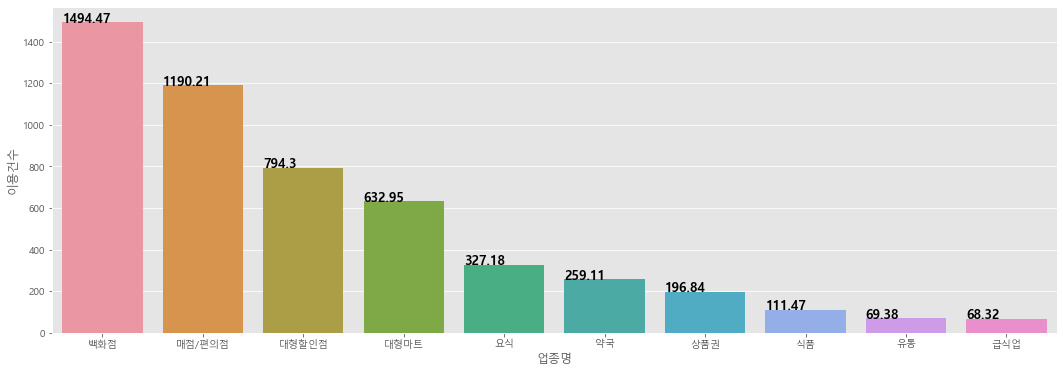

In [143]:
sub_table = card_index_sub.pivot_table(index=['업종명'], values=['이용건수'], aggfunc='mean')
sub_table = sub_table.sort_values(by = '이용건수', ascending=False)
sub_table_10 = sub_table.iloc[:10, :]
sub_table_10 = sub_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', sub_table_10.shape[0])

top_down_index = sub_table_10['이용건수'].sort_values(ascending=False).index
plot_order = sub_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = '이용건수', data = sub_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
sub_table_10 = sub_table_10.sort_values(by = '이용건수', ascending=False)
sub_table_10['이용건수'] = np.round(sub_table_10['이용건수'], 2)
    
for idx, score in enumerate(sub_table_10['이용건수']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [144]:
sub_table_10.to_csv("data/post_covid_sub.csv", index=False)

# 해석 : 물류를 많이 시키는 지역에서 백화점, 매점,편의점 대형 할인점 등의 소비가 많았다
=> 이 중에서 구독경제를 도입할만한 애를 찾아보는것도 좋을듯

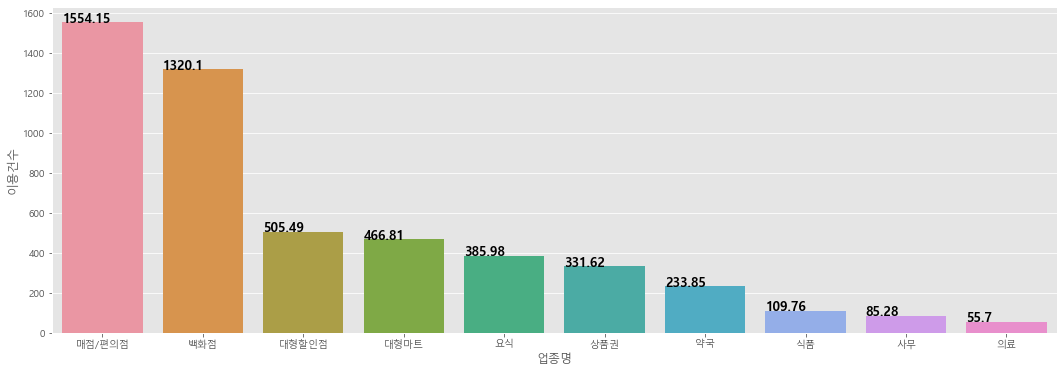

In [145]:
drive_table = card_index_drive.pivot_table(index=['업종명'], values=['이용건수'], aggfunc='mean')
drive_table = drive_table.sort_values(by = '이용건수', ascending=False)
drive_table_10 = drive_table.iloc[:10, :]
drive_table_10 = drive_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', drive_table_10.shape[0])

top_down_index = drive_table_10['이용건수'].sort_values(ascending=False).index
plot_order = drive_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = '이용건수', data = drive_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
drive_table_10 = drive_table_10.sort_values(by = '이용건수', ascending=False)
drive_table_10['이용건수'] = np.round(drive_table_10['이용건수'], 2)
    
for idx, score in enumerate(drive_table_10['이용건수']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [146]:
drive_table_10.to_csv("data/post_covid_drive.csv", index=False)

# 해석 : 차량지수가 높은 곳에서 매점/편의점, 백화점에 대한 수요가 높았다.

# 해석 : 물류지수와 공통적으로 높은것으로 보아 이 두 산업군에다가만 드라이브 스루 / 구독경제를 어떻게 도입할 지를 찾아봐도 좋을듯?

# 전체지도

In [147]:
# 은평구는 X로 추가
data = index_group[['구명', 'result']]

na = pd.DataFrame(['은평구', 'X'], index = ['구명', 'result']).T

data = data.append(na)
data = data.reset_index(drop=True)

result_dic = {
    'X' : 0,
    '구독경제' : 1,
    '드라이브스루' : 2,
    'O' : 3
}

data.result = data['result'].map(result_dic)

import folium
import pandas as pd

geo_json = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"

m = folium.Map(
    location = [37.566345, 126.977893],
    tiles = 'Mapbox Bright')

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data=data,
    columns = ['구명', 'result'],
    key_on = 'feature.properties.name',
    fill_color= 'YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

# 드라이브 스루 지도

In [148]:
# 은평구는 X로 추가
data = index_group[['구명', 'result']]

na = pd.DataFrame(['은평구', 'X'], index = ['구명', 'result']).T

data = data.append(na)
data = data.reset_index(drop=True)

result_dic = {
    'X' : 0,
    '구독경제' : 0,
    '드라이브스루' : 1,
    'O' : 1
}

data.result = data['result'].map(result_dic)

geo_json = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"

m = folium.Map(
    location = [37.566345, 126.977893],
    tiles = 'Mapbox Bright')

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data=data,
    columns = ['구명', 'result'],
    key_on = 'feature.properties.name',
    fill_color= 'PuRd',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

# 구독경제 지도

In [149]:
# 은평구는 X로 추가
data = index_group[['구명', 'result']]

na = pd.DataFrame(['은평구', 'X'], index = ['구명', 'result']).T

data = data.append(na)
data = data.reset_index(drop=True)

result_dic = {
    'X' : 0,
    '구독경제' : 1,
    '드라이브스루' : 0,
    'O' : 1
}

data.result = data['result'].map(result_dic)

geo_json = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"

m = folium.Map(
    location = [37.566345, 126.977893],
    tiles = 'Mapbox Bright')

folium.Choropleth(
    geo_data = geo_json,
    name = 'choropleth',
    data=data,
    columns = ['구명', 'result'],
    key_on = 'feature.properties.name',
    fill_color= 'BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

m

In [150]:
# 물류데이터 저장
logistic_df.to_csv("data/logistic_df.csv", index=False)

In [151]:
# 차량데이터 저장
car_df.to_csv("data/car_df.csv", index=False)

In [152]:
card_index = card_df.pivot_table(index=['주차', '구명', '업종명'], values='이용건수', aggfunc='mean').reset_index()

card_index_pre = card_index[(card_index['주차'] == 4) | (card_index['주차'] == 5)]
card_index_post = card_index[(card_index['주차'] == 23) | (card_index['주차'] == 24)]

In [153]:
card_index_pre = card_index_pre.pivot_table(index=['구명','업종명'], values='이용건수', aggfunc='mean').reset_index()
card_index_post = card_index_post.pivot_table(index=['구명','업종명'], values='이용건수', aggfunc='mean').reset_index()

In [154]:
card_index_total = card_index_pre.merge(card_index_post, how = 'inner', on = ['구명', '업종명'])

card_index_total.columns = ['구명', '업종명', '이용건수_pre', '이용건수_post']

In [155]:
card_sub = card_index_total[card_index_total['구명'].isin(sub_group_gu)]
card_drive = card_index_total[card_index_total['구명'].isin(drive_group_gu)]

card_sub = card_sub.reset_index(drop = True)
card_drive = card_drive.reset_index(drop = True)

In [156]:
card_sub['new_normal'] = card_sub['이용건수_post'] - card_sub['이용건수_pre']
card_drive['new_normal'] = card_drive['이용건수_post'] - card_drive['이용건수_pre']

In [157]:
card_drive

,구명,업종명,이용건수_pre,이용건수_post,new_normal
0,강서구,가구,2.967692,3.035806,0.068114
1,강서구,가전,10.204198,11.030077,0.825878
2,강서구,건강,12.202796,12.273923,0.071127
3,강서구,교육,7.986305,4.296695,-3.689610
4,강서구,급식업,45.298942,35.142380,-10.156561
...,...,...,...,...,...
209,중랑구,주류,2.325000,1.548611,-0.776389
210,중랑구,주방,4.975490,6.100611,1.125121
211,중랑구,주점,35.804788,42.246269,6.441480
212,중랑구,컴퓨터,2.365497,3.119091,0.753594


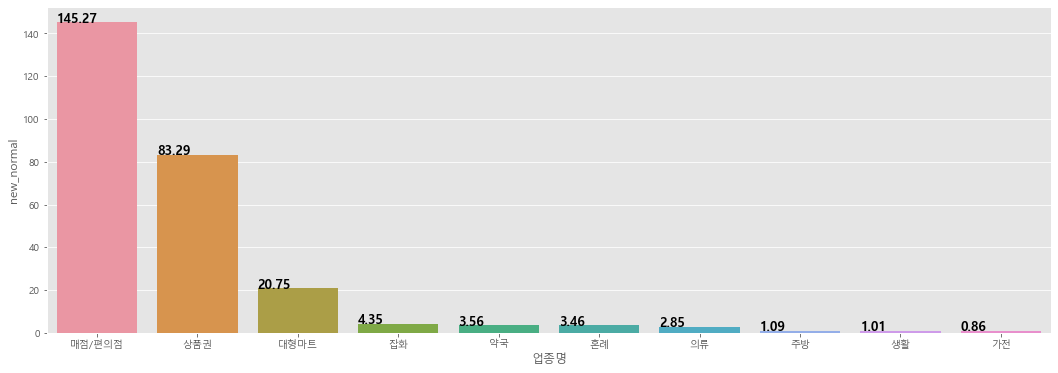

In [158]:
sub_table = card_drive.pivot_table(index=['업종명'], values=['new_normal'], aggfunc='mean')
sub_table = sub_table.sort_values(by = 'new_normal', ascending=False)
sub_table_10 = sub_table.iloc[:10, :]
sub_table_10 = sub_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', sub_table_10.shape[0])

top_down_index = sub_table_10['new_normal'].sort_values(ascending=False).index
plot_order = sub_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = 'new_normal', data = sub_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
sub_table_10 = sub_table_10.sort_values(by = 'new_normal', ascending=False)
sub_table_10['new_normal'] = np.round(sub_table_10['new_normal'], 2)
    
for idx, score in enumerate(sub_table_10['new_normal']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [159]:
sub_table_10.to_csv("data/post_covid_drive_frequent.csv", index=False)

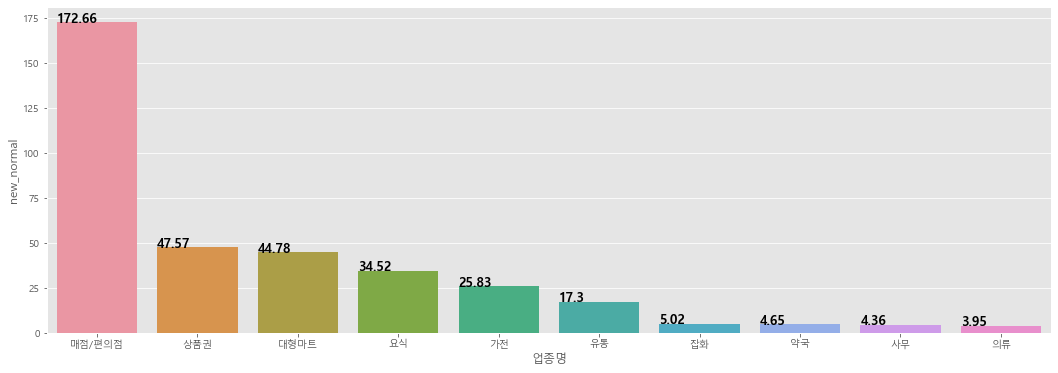

In [160]:
sub_table = card_sub.pivot_table(index=['업종명'], values=['new_normal'], aggfunc='mean')
sub_table = sub_table.sort_values(by = 'new_normal', ascending=False)
sub_table_10 = sub_table.iloc[:10, :]
sub_table_10 = sub_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', sub_table_10.shape[0])

top_down_index = sub_table_10['new_normal'].sort_values(ascending=False).index
plot_order = sub_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = 'new_normal', data = sub_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
sub_table_10 = sub_table_10.sort_values(by = 'new_normal', ascending=False)
sub_table_10['new_normal'] = np.round(sub_table_10['new_normal'], 2)
    
for idx, score in enumerate(sub_table_10['new_normal']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [161]:
sub_table_10.to_csv("data/post_covid_sub_frequent.csv", index=False)

In [162]:
card_index = card_df.pivot_table(index=['주차', '구명', '업종명'], values='이용금액', aggfunc='mean').reset_index()

card_index_pre = card_index[(card_index['주차'] == 4) | (card_index['주차'] == 5)]
card_index_post = card_index[(card_index['주차'] == 23) | (card_index['주차'] == 24)]

In [163]:
card_index_pre = card_index_pre.pivot_table(index=['구명','업종명'], values='이용금액', aggfunc='mean').reset_index()
card_index_post = card_index_post.pivot_table(index=['구명','업종명'], values='이용금액', aggfunc='mean').reset_index()

In [164]:
card_index_total = card_index_pre.merge(card_index_post, how = 'inner', on = ['구명', '업종명'])

card_index_total.columns = ['구명', '업종명', '이용금액_pre', '이용금액_post']

In [165]:
card_sub = card_index_total[card_index_total['구명'].isin(sub_group_gu)]
card_drive = card_index_total[card_index_total['구명'].isin(drive_group_gu)]

card_sub = card_sub.reset_index(drop = True)
card_drive = card_drive.reset_index(drop = True)

In [166]:
card_sub['new_normal'] = card_sub['이용금액_post'] - card_sub['이용금액_pre']
card_drive['new_normal'] = card_drive['이용금액_post'] - card_drive['이용금액_pre']

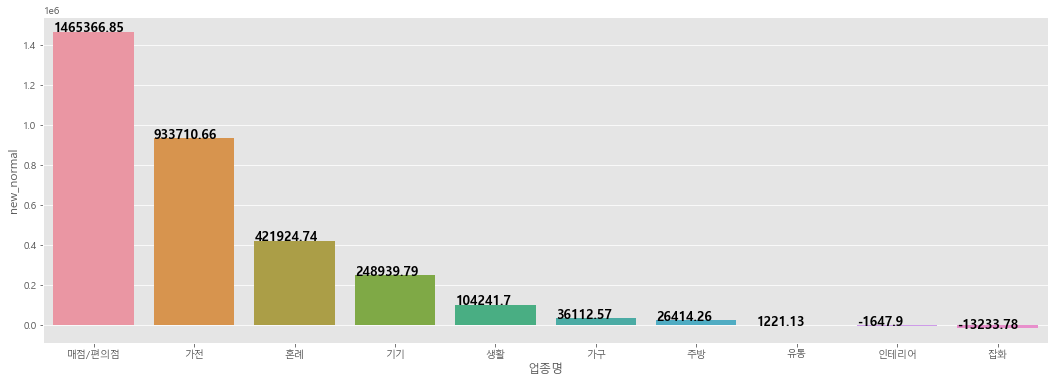

In [167]:
sub_table = card_drive.pivot_table(index=['업종명'], values=['new_normal'], aggfunc='mean')
sub_table = sub_table.sort_values(by = 'new_normal', ascending=False)
sub_table_10 = sub_table.iloc[:10, :]
sub_table_10 = sub_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', sub_table_10.shape[0])

top_down_index = sub_table_10['new_normal'].sort_values(ascending=False).index
plot_order = sub_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = 'new_normal', data = sub_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
sub_table_10 = sub_table_10.sort_values(by = 'new_normal', ascending=False)
sub_table_10['new_normal'] = np.round(sub_table_10['new_normal'], 2)
    
for idx, score in enumerate(sub_table_10['new_normal']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [168]:
sub_table_10.to_csv("data/post_covid_drive_amount.csv", index=False)

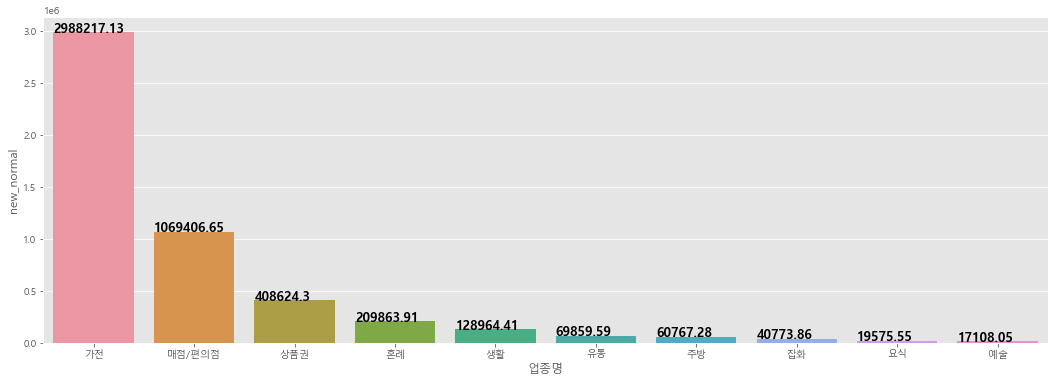

In [169]:
sub_table = card_sub.pivot_table(index=['업종명'], values=['new_normal'], aggfunc='mean')
sub_table = sub_table.sort_values(by = 'new_normal', ascending=False)
sub_table_10 = sub_table.iloc[:10, :]
sub_table_10 = sub_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', sub_table_10.shape[0])

top_down_index = sub_table_10['new_normal'].sort_values(ascending=False).index
plot_order = sub_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = 'new_normal', data = sub_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
sub_table_10 = sub_table_10.sort_values(by = 'new_normal', ascending=False)
sub_table_10['new_normal'] = np.round(sub_table_10['new_normal'], 2)
    
for idx, score in enumerate(sub_table_10['new_normal']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [170]:
sub_table_10.to_csv("data/post_covid_sub_amount.csv", index=False)

In [171]:
sub_group_gu = index_group[(index_group['result'] == 'O') | (index_group['result'] == '구독경제')]['구명'].to_list()
drive_group_gu = index_group[(index_group['result'] == 'O') | (index_group['result'] == '드라이브스루')]['구명'].to_list()

In [172]:
card_index = card_df.pivot_table(index=['주차', '구명', '업종명'], values='이용건수', aggfunc='mean').reset_index()

card_index_sep = card_index[(card_index['주차'] == 4) | (card_index['주차'] == 5)]
card_index_sep = card_index_sep.reset_index(drop=True)

In [173]:
card_index_sub = card_index_sep[card_index_sep['구명'].isin(sub_group_gu)]
card_index_drive = card_index_sep[card_index_sep['구명'].isin(drive_group_gu)]

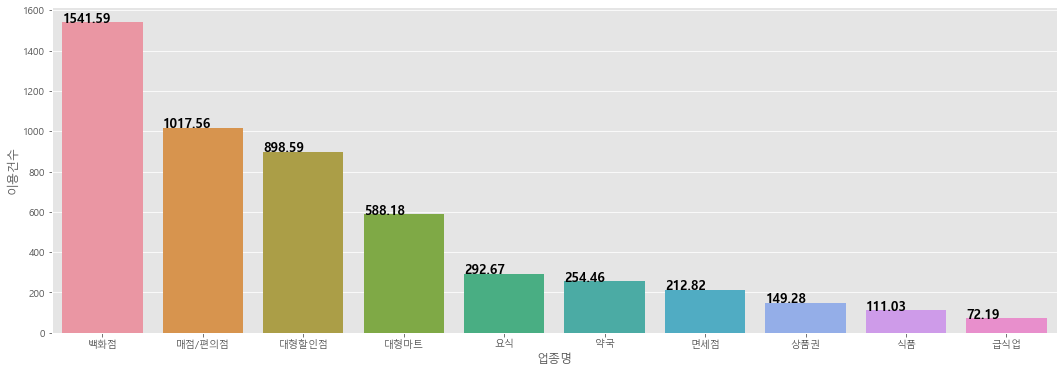

In [174]:
sub_table = card_index_sub.pivot_table(index=['업종명'], values=['이용건수'], aggfunc='mean')
sub_table = sub_table.sort_values(by = '이용건수', ascending=False)
sub_table_10 = sub_table.iloc[:10, :]
sub_table_10 = sub_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', sub_table_10.shape[0])

top_down_index = sub_table_10['이용건수'].sort_values(ascending=False).index
plot_order = sub_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = '이용건수', data = sub_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
sub_table_10 = sub_table_10.sort_values(by = '이용건수', ascending=False)
sub_table_10['이용건수'] = np.round(sub_table_10['이용건수'], 2)
    
for idx, score in enumerate(sub_table_10['이용건수']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

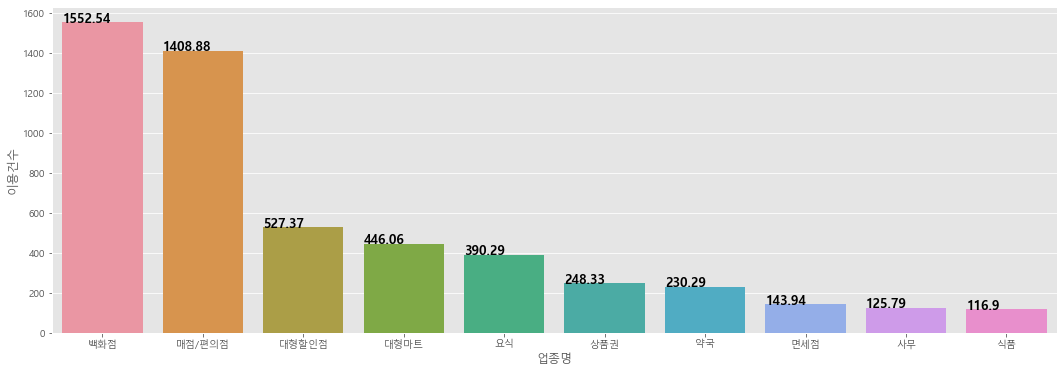

In [175]:
drive_table = card_index_drive.pivot_table(index=['업종명'], values=['이용건수'], aggfunc='mean')
drive_table = drive_table.sort_values(by = '이용건수', ascending=False)
drive_table_10 = drive_table.iloc[:10, :]
drive_table_10 = drive_table_10.reset_index()

plt.figure(figsize=(18, 6))

pal = sns.color_palette('Blues_r', drive_table_10.shape[0])

top_down_index = drive_table_10['이용건수'].sort_values(ascending=False).index
plot_order = drive_table_10.iloc[top_down_index]['업종명'].values
    
sns.barplot(x = '업종명', y = '이용건수', data = drive_table_10, order = plot_order)
    
# plt.axhline(sub_table['이용건수'].mean())
drive_table_10 = drive_table_10.sort_values(by = '이용건수', ascending=False)
drive_table_10['이용건수'] = np.round(drive_table_10['이용건수'], 2)
    
for idx, score in enumerate(drive_table_10['이용건수']):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')